In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py # https://pypi.org/project/h5py/
import spatiotemporal # https://pypi.org/project/spatiotemporal/
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import scipy
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
import gc

/Users/max/PycharmProjects/fmri_project/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
# Extract all timeseries from hdf5 file
f = h5py.File("timeseries_max_all_subjects.hdf5", "r")
tss = f['timeseries'] # Subject timeseries, four sessions of 360 timeseries for each subject

In [6]:
# Extract data
raw_features = []
all_features = []
subjnum = []
scannum = []
label = []
nr_subj = len(tss.keys()) #883 in total
for i,subj in enumerate(tss.keys()):
    if i%100==0:
        print(i)
    if i>nr_subj: break # Just x subjects so that it runs faster
    for j,scan in enumerate(tss[subj].keys()): # 4 scans roughly per subject
        # extract raw time series
        ts_np = np.asarray(tss[subj][scan]).T # 360 (=nr_voxels) x 1100
        raw_features += [ts_np]
        # extract variance and AR(1) coefficient (roughly 1st and 2nd term of ACF)
        ar1s = spatiotemporal.stats.temporal_autocorrelation(ts_np)
        var = np.var(tss[subj][scan], axis=0)
        var_norm = var/np.max(var)
        all_features.append(np.concatenate([ar1s, var_norm]))
        subjnum.append(i)
        scannum.append(j)
        label += [(i,j)]

0
100
200
300
400
500
600
700
800


In [7]:
# transform to arrays
all_features = np.asarray(all_features) # (nr_scans * nr_subjects) x (nr_voxels * nr_features)
subjnum = np.asarray(subjnum)
scannum = np.asarray(scannum)
label = np.asarray(label) # [[nr of subject, nr of scan],...]
raw_features = np.asarray(raw_features) # (nr_scans * nr_subjects) x (nr_voxels) x (length ts)

In [11]:
# Create a matrix that will allow to query same or different pairs; 
# element (i,j) of the matrix = True if same subject and False if different subject
same_subject = (subjnum[:,None] == subjnum[None,:]) & (scannum[:,None] != scannum[None,:])
# element (i,j) of the matrix = True if different subjects and False if same
diff_subject = (subjnum[:,None] != subjnum[None,:])

In [12]:
# Optional cell to run some tests
print(all_features.min())

-0.11737216219878091


### Let's build a baseline where we compute accuracy and clustering just based on random features
Note: we need to change this to the *best* features

In [22]:
sames

array([0.36117292, 0.23314991, 0.48069117, ..., 0.32656017, 0.19132941,
       0.23784845])

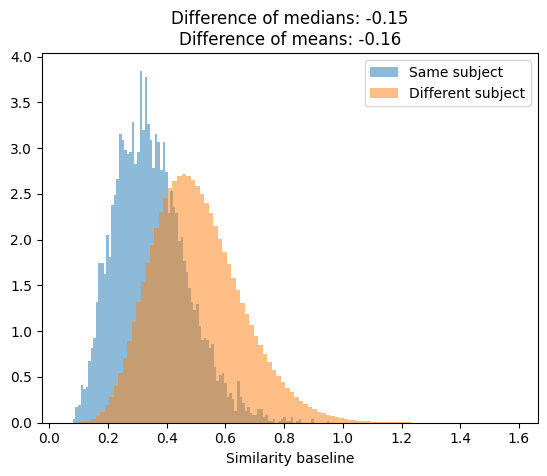

Clustering using a distance threshold
Accuracy on same: 0.8884484711211778
Accuracy on different: 0.4725942660945088
Clustering using KMeans with k=10
Accuracy on same: 0.3052095130237826
Accuracy on different: 0.8945825404529498
Cluster = 0
Patient ids in cluster = [  2   4   7  11  11  11  11  14  14  16  23  24  25  25  25  30  37  38
  39  39  54  54  54  57  57  58  58  62  68  69  74  75  77  77  84  85
  85 101 101 101 103 106 107 107 108 114 114 115 121 122 122 124 124 125
 125 125 137 145 145 145 146 147 147 155 155 155 156 160 160 160 161 170
 173 173 173 175 183 183 184 192 192 194 200 200 201 201 201 205 208 210
 215 220 221 222 223 226 229 229 231 234 235 235 238 250 257 258 261 270
 278 278 278 278 283 284 287 287 291 291 292 292 292 292 293 293 293 304
 312 312 312 313 315 317 317 317 317 318 322 324 328 329 330 336 345 345
 345 345 352 353 353 353 354 357 357 357 357 359 359 365 367 367 367 371
 371 375 382 389 392 392 396 402 404 404 409 409 416 417 417 420 422 423
 42

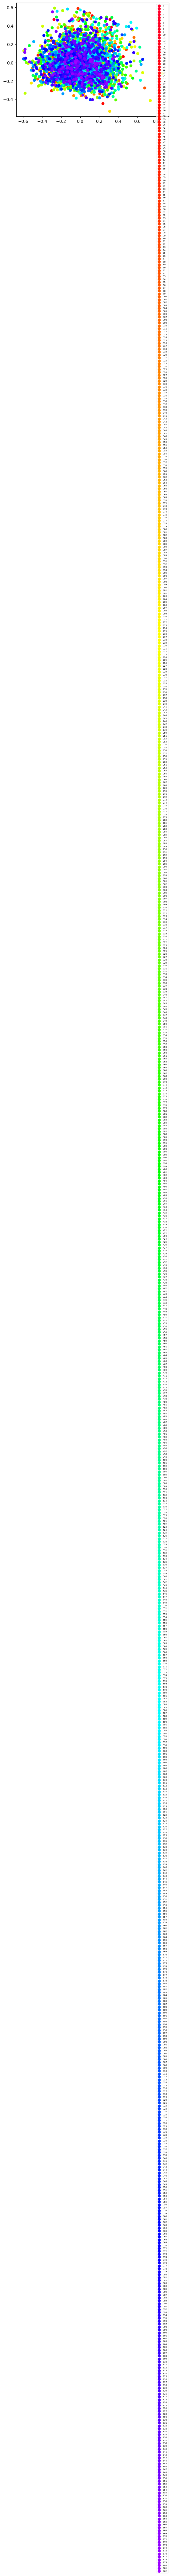

In [63]:
dim_of_choice = 10
inds = np.random.permutation(360*2) < dim_of_choice
encodings = all_features[:,inds]
dist_random = cdist(encodings, encodings)

# Evaluation 0: mean / median plot;
# We want the distance for different to be very different from distance for same
sames = dist_random[same_subject]
diffs = dist_random[diff_subject]
plt.hist(sames, bins=100, density=True, alpha=.5)
plt.hist(diffs, bins=100, density=True, alpha=.5)
plt.xlabel("Similarity baseline")
plt.legend(["Same subject", "Different subject"])
plt.title(f"Difference of medians: {np.median(sames)-np.median(diffs):.2f}\nDifference of means: {np.mean(sames)-np.mean(diffs):.2f}")
plt.show()

# Evaluation 1: we compute the accuracy of the same/diff classification
threshold = 0.5 # something we set (no idea how...)
ran_diff = (dist_random>threshold) # True if above threshold
ran_same = (dist_random<=threshold)

accuracy_same = np.sum((ran_same==same_subject) & (ran_same==True) & (same_subject==True))/np.sum(same_subject)
accuracy_diff = np.sum((ran_diff==diff_subject) & (ran_diff==True) & (diff_subject==True)) / np.sum(diff_subject)
print('Clustering using a distance threshold')
print('Accuracy on same: '+str(accuracy_same))
print('Accuracy on different: '+str(accuracy_diff))

# Note: what is actually being computed here is accuracy_same = recall, accuracy_diff = specificity

# Evaluation 2: perform a clustering using the embeddings
kmeans = KMeans(n_clusters=10, random_state=0, n_init=10).fit(encodings)
labels_val = kmeans.labels_

# Compute recall and specificity for the K-means classifier
kmeans_label_classifier = labels_val.reshape(-1,1) == labels_val
accuracy_same_kmeans = np.sum(kmeans_label_classifier[same_subject])/np.sum(same_subject)
accuracy_diff_kmeans = np.sum(~kmeans_label_classifier[diff_subject])/np.sum(diff_subject)
print(f'Clustering using KMeans with k={kmeans.n_clusters}')
print(f'Accuracy on same: {accuracy_same_kmeans}')
print(f'Accuracy on different: {accuracy_diff_kmeans}')

# print the cluster labels and true patient id's
for g in np.unique(labels_val):
    ix = np.where(labels_val==g)
    print('Cluster = '+str(g))
    print('Patient ids in cluster = '+ str(subjnum[ix]))

# Create a scatter plot with the color being true patient id
cm = plt.cm.gist_rainbow(np.linspace(0,1,1000))
# Use PCA to plot 2 important dimensions 
if dim_of_choice > 2: 
    val_pca = PCA(n_components=2).fit_transform(encodings)# input is (nr_samples, nr_dim)
    print(val_pca.shape)
else: 
    val_pca = encodings
it = 0
for g in np.unique(subjnum):
    ix = np.where(subjnum == g)
    plt.scatter(val_pca[ix,0], val_pca[ix,1], color = cm[it], label = g)
    it += 1
plt.legend(loc=0, prop={'size': 5})
plt.show()


### Define contrastive losses

In [64]:
# Define the different contrastive losses that I will use 

def contr_loss_simple(output, same, diff, eps):
    # note that when computing the gradient here, we thus need to iterate over all N^2 pairs (N is batchsize)
    dist = torch.cdist(output, output, p=2) # gives matrix with (i,j) = l2 norm of (output[i:]-output[j:])
    loss_same = torch.mean(torch.pow(torch.masked_select(dist, same), 2))
    loss_diff = torch.mean(torch.pow(torch.clamp(eps - torch.masked_select(dist, diff),0), 2))
    #return (loss_same + loss_diff)**2 / (dist.shape[0]*dist.shape[1])
    return loss_same + loss_diff

def contr_loss_lifted(output, same, diff, eps):
    dist = torch.cdist(output, output, p=2) # gives matrix with (i,j) = l2 norm of (output[i:]-output[j:])
    pos_indices = torch.argwhere(same) # size (nr_pos, 2)
    
    # for each pair in the positive pairs, compute negative distances
    pos_pair1 = pos_indices[:,0] # get first positive pair index
    pos_pair2 = pos_indices[:,1] # get second positive pair index
    # find the largest distance between first/second positive index and its negative partner
    # note: dist[pos_pair1,:] is a matrix of size (nr_pos_pairs, nr_pairs) & diff[pos_pair1,:] is matrix w/ True/False
    dist_pospair1 = dist[pos_pair1,:]
    dist_pospair1[diff[pos_pair1,:]==False] = np.inf
    max1 = torch.exp(eps - dist_pospair1)
    dist_pospair2 = dist[pos_pair2,:]
    dist_pospair2[diff[pos_pair2,:]==False] = np.inf
    max2 = torch.exp(eps - dist_pospair2)
    max_12 = torch.log(torch.sum(max1, axis = 1) + torch.sum(max2, axis = 1)) # sum over all pairs -> output is [nr_pos_pairs1]
    sum_all = torch.max(torch.tensor(0), max_12 + torch.masked_select(dist, same)) # should be size
    return torch.sum(sum_all)/(2*pos_indices.shape[0])
    
#     sum_all = 0
#     nr_sum = 0
#     for pos_pair in pos_indices: # this can be changed to a subset only
#         pos_pair1 = pos_pair[0]
#         pos_pair2 = pos_pair[1]
#         # take the pos_pair1,2 rows and take the dist there
#         max1 = torch.exp(eps - torch.masked_select(dist[pos_pair1,:], diff[pos_pair1,:])) # diff[pos_pair1,:] is vector w/ True/False
#         max2 = torch.exp(eps - torch.masked_select(dist[pos_pair2,:], diff[pos_pair2,:]))
#         max_12 = torch.log(torch.sum(max1) + torch.sum(max2))
#         sum_all += torch.max(torch.tensor(0), max_12 + dist[pos_pair1,pos_pair2])**2
#         nr_sum += 1
#     return sum_all / (2*nr_sum)

### Let's use now a neural network optimised with contrastive loss over the time series features

In [66]:
# Create dataloader 
class ourDataset(Dataset):
    def __init__(self, the_data, the_device):
        self.dataset = the_data
        self.the_device = the_device

    def __len__(self):
        return (self.dataset).shape[0]

    def __getitem__(self, idx):
        # Load the data
        datapoint = self.dataset[idx,:]
        batch_idx = idx
        # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
        datapoint = torch.tensor(datapoint, dtype=torch.float).to(self.the_device)
        return datapoint, batch_idx

In [67]:
class Net(nn.Module):
  def __init__(self, dim, nenc, width, depth):
    super().__init__()
    self.flatten = nn.Flatten()
    modules = []
    modules.append(nn.BatchNorm1d(dim))
    modules.append(nn.Linear(dim, width))
    modules.append(nn.ReLU())
    for dp in range(depth):
        modules.append(nn.BatchNorm1d(width))
        modules.append(nn.Linear(width, width))
        modules.append(nn.ReLU())
    modules.append(nn.Linear(width, nenc)) # output is thus something of size nenc, the size of the encoding
    self.sequential = nn.Sequential(*modules)

  def forward(self, input):
    x = self.flatten(input) # equivalently, x = x.view(x.size()[0], -1)
    output = self.sequential.forward(x)
    return output

In [68]:
batch_size = 512
dim = all_features.shape[1]
width = 64
depth = 2
nenc = 1
nr_epochs = 500

loss_c = 'simple'
if loss_c == 'simple':
    eps = 10
    lr = .01
elif loss_c == 'lifted':
    eps = 10
    lr = .01

net = Net(dim, nenc, width, depth)
device = 'cpu'
optimizer = optim.SGD(net.parameters(), lr=lr)

# Create train and test datasets
perc_train = 75
nr_samples = all_features.shape[0]
print('Number of total samples= '+ str(nr_samples))
num_train = int(np.round(nr_samples / 100 * perc_train))
# I want to select a set of patients as train and the rest as val (point being, both should contain enough same patients)
idxs = np.arange(nr_samples)
idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]
# shuffle after selecting
np.random.shuffle(idxs_train)
np.random.shuffle(idxs_val)

same_subject_train = same_subject[idxs_train[:,None], idxs_train[None,:]]
same_subject_val = same_subject[idxs_val[:,None], idxs_val[None,:]]
diff_subject_train = diff_subject[idxs_train[:,None], idxs_train[None,:]]
diff_subject_val = diff_subject[idxs_val[:,None], idxs_val[None,:]]
all_features_train = all_features[idxs_train,:]
all_features_val = all_features[idxs_val,:]

# Load data
dataset_train = ourDataset(all_features_train, the_device=device)
train_dataloader = DataLoader(dataset_train, batch_size=batch_size) #shuffle is false as i've shuffled already

for epoch in range(nr_epochs):
    # iterate over all data 
    for (d,batch_idx) in train_dataloader:
        batch_idx = batch_idx.detach().numpy()
        # get submatrices of same and diff
        same = torch.tensor(same_subject_train[batch_idx[:,None], batch_idx[None,:]])
        diff = torch.tensor(diff_subject_train[batch_idx[:,None], batch_idx[None,:]])
        # pass through model
        output = net.forward(d)
        # Compute the loss value
        if loss_c == 'simple':
            loss = contr_loss_simple(output, same, diff, eps)
        elif loss_c == 'lifted':
            loss = contr_loss_lifted(output, same, diff, eps)
        # zero the parameter gradients
        optimizer.zero_grad()
        # Compute the gradients
        loss.backward()
        # Take the optimisation step
        optimizer.step()
    if epoch%10==0:
        print(epoch, loss.item())

print('Finished training')
print('Final loss ' + str(loss.item()))

Number of total samples= 3532
0 58.786827087402344
10 22.60549545288086
20 13.45589542388916
30 9.80082893371582
40 8.069778442382812
50 8.094300270080566
60 16.950092315673828
70 12.162627220153809
80 7.351970672607422
90 7.524579048156738
100 5.764152526855469
110 5.777729511260986
120 4.799612045288086
130 6.005977630615234
140 5.579741954803467
150 5.158157825469971
160 4.220982551574707
170 3.517385721206665
180 5.985102653503418
190 5.420383453369141
200 4.96431303024292
210 3.82470440864563
220 4.799859046936035
230 5.030019760131836
240 4.013906002044678
250 8.684253692626953
260 4.315586090087891
270 4.2850470542907715
280 3.2737205028533936
290 2.6099801063537598
300 2.4853384494781494
310 2.732229709625244
320 3.9702181816101074
330 2.2713537216186523
340 3.576950788497925
350 3.4324331283569336
360 3.343822479248047
370 2.0601348876953125
380 2.6211209297180176
390 2.7498691082000732
400 1.9995814561843872
410 2.2538294792175293
420 2.4703903198242188
430 2.34324049949646
4

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 32.24it/s]


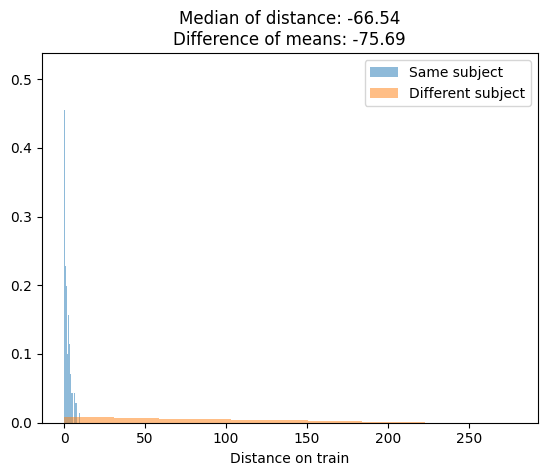

In [69]:
# Evaluation 00: mean / median plot on TRAIN
# We want the distance for different to be very different from distance for same

sames = []
diffs = []
for it, (d,batch_idx) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    output = net.forward(d)
    dist_train = torch.cdist(output, output)
    labels_same = same_subject_train[batch_idx[:,None],batch_idx[None,:]]
    labels_diff = diff_subject_train[batch_idx[:,None],batch_idx[None,:]]
    sames.append(dist_train[labels_same].detach().numpy())
    diffs.append(dist_train[labels_diff].detach().numpy())
sames = np.hstack(sames)
diffs = np.hstack(diffs)

plt.hist(sames, bins=100, density=True, alpha=.5)
plt.hist(diffs, bins=100, density=True, alpha=.5)
plt.xlabel("Distance on train")
plt.legend(["Same subject", "Different subject"])
plt.title(f"Median of distance: {np.median(sames)-np.median(diffs):.2f}\nDifference of means: {np.mean(sames)-np.mean(diffs):.2f}")
plt.show()

#### Implement the evaluation metrics. We will work with the validation dataset

In [70]:
dataset_val = ourDataset(all_features_val, the_device=device)
val_dataloader = DataLoader(dataset_val, batch_size=len(idxs_val))

# pass through model
output_val = []
index_val = []
for it, (d,batch_idx) in enumerate(val_dataloader):
    output = net.forward(d)
    output_val.append(output.detach().numpy())
    index_val.append(batch_idx.detach().numpy())
output_val = np.vstack(output_val)
index_val = np.hstack(index_val)

dist_val = cdist(output_val, output_val)
# get submatrices of same and diff
same_val_true = same_subject_val[index_val[:,None], index_val[None,:]]
diff_val_true = diff_subject_val[index_val[:,None], index_val[None,:]]

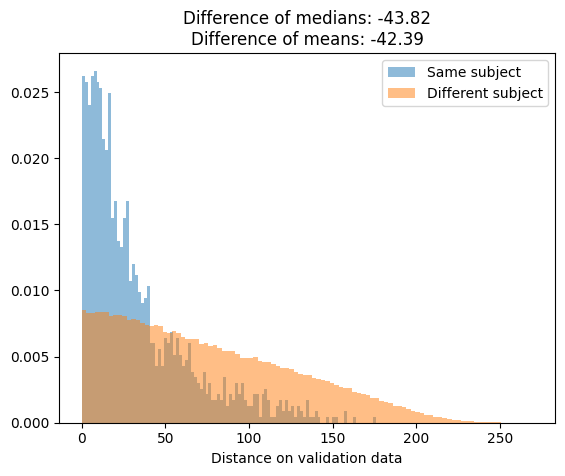

In [71]:
# Evaluation 0: mean / median plot; 
# We want the distance for different to be very different from distance for same
sames = dist_val[same_val_true]
diffs = dist_val[diff_val_true]
plt.hist(sames, bins=100, density=True, alpha=.5)
plt.hist(diffs, bins=100, density=True, alpha=.5)
plt.xlabel("Distance on validation data")
plt.legend(["Same subject", "Different subject"])
plt.title(f"Difference of medians: {np.median(sames)-np.median(diffs):.2f}\nDifference of means: {np.mean(sames)-np.mean(diffs):.2f}")
plt.show()

In [72]:
# Evaluation 1: we compute the accuracy of the same/diff classification
threshold = eps # REQUIRES LOTS OF TUNING
same_val_pred = (dist_val<=threshold) # True if above threshold
diff_val_pred = (dist_val>threshold)

accuracy_same = np.sum((same_val_pred==same_val_true) & (same_val_true==True))/np.sum(same_val_true)
accuracy_diff = np.sum((diff_val_true==diff_val_pred) & (diff_val_true==True)) / np.sum(diff_val_true)
print('Accuracy on same: '+str(accuracy_same))
print('Accuracy on different: '+str(accuracy_diff))

Accuracy on same: 0.25547996976568405
Accuracy on different: 0.9162105751391466


Total number of patients in validation set is 221
Clustering using KMeans with k=10
Accuracy on same: 0.3250188964474679
Accuracy on different: 0.8947381983096269
Cluster = 0
Patient ids in cluster = [664 664 664 664 669 673 673 673 673 686 711 711 711 715 717 725 729 729
 732 732 732 732 733 735 735 735 735 740 741 741 748 748 748 748 753 753
 756 769 769 769 776 776 776 797 797 800 800 818 820 820 822 826 828 828
 831 831 831 831 832 832 832 835 838 838 838 846 847 855 859 859 866 876
 880]


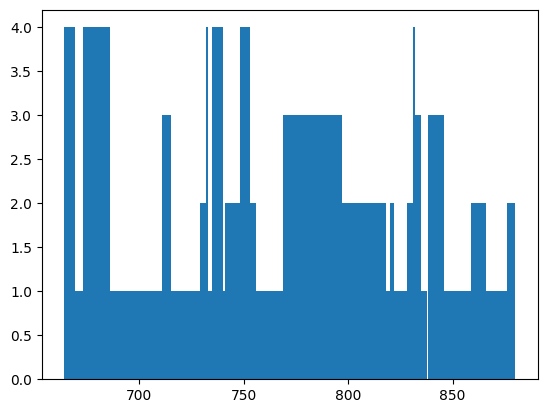

Cluster = 1
Patient ids in cluster = [663 669 671 671 676 677 678 682 682 683 687 690 695 701 705 705 706 718
 718 724 725 726 727 727 727 730 737 738 740 750 754 754 757 757 757 757
 759 761 762 764 766 775 779 779 779 785 785 790 790 791 791 792 792 793
 793 794 799 804 806 806 807 813 816 816 823 824 824 826 830 836 841 841
 841 842 843 849 850 850 850 853 857 857 858 861 861 863 863 863 869 869
 875 876 878 878]


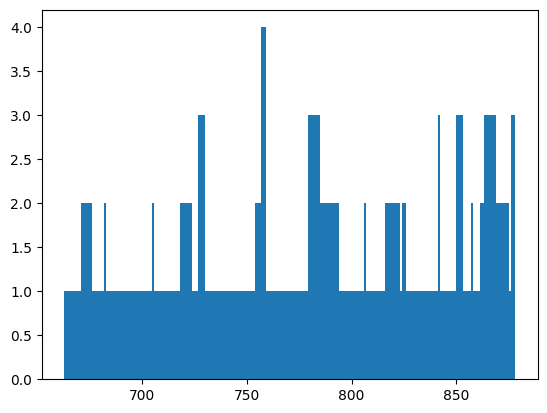

Cluster = 2
Patient ids in cluster = [667 668 668 668 672 672 674 676 680 682 687 688 690 693 693 695 696 719
 721 724 726 734 736 736 737 738 739 743 746 746 751 758 760 760 761 762
 763 764 772 772 773 773 774 775 775 778 780 781 781 795 795 801 801 802
 802 804 805 808 808 809 809 810 810 825 825 839 844 851 860 862 862 869
 870 881 882]


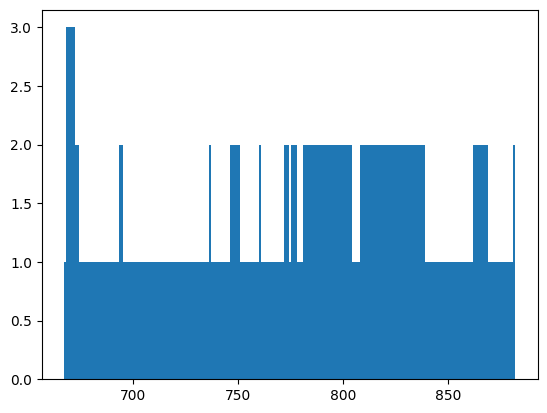

Cluster = 3
Patient ids in cluster = [663 663 665 670 684 684 687 687 688 688 691 692 697 698 698 698 701 701
 702 707 707 707 709 710 712 712 712 713 714 714 714 714 715 716 716 720
 720 728 730 733 733 734 745 747 747 750 754 759 759 760 766 766 767 767
 771 771 780 782 786 789 790 790 791 796 807 812 813 813 814 817 818 819
 821 827 827 829 829 830 833 833 835 835 836 838 839 840 840 840 843 843
 845 845 846 848 848 856 856 858 858 865 871 872 876 877 877 877 880]


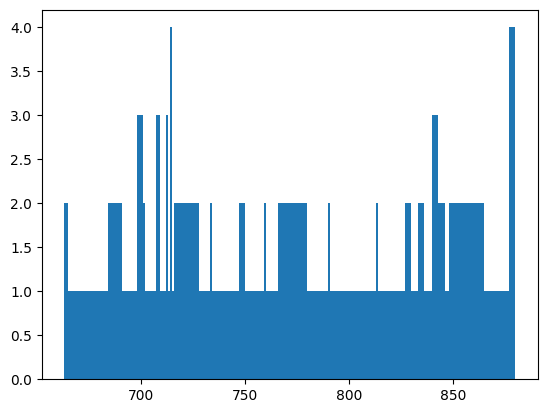

Cluster = 4
Patient ids in cluster = [666 666 666 666 672 674 675 681 681 681 681 694 694 694 696 699 699 699
 699 704 704 704 722 749 749 763 768 768 768 768 774 777 778 808 844 844
 844 867 867 867]


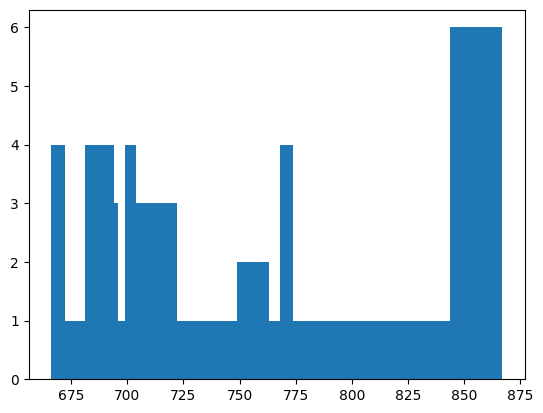

Cluster = 5
Patient ids in cluster = [665 670 672 675 676 680 680 690 690 692 692 693 693 696 702 702 705 707
 717 721 725 726 737 738 738 742 742 743 745 745 746 746 750 751 755 758
 765 765 772 773 773 781 784 784 788 788 788 792 794 795 796 798 802 804
 804 805 808 809 809 810 810 812 812 815 815 819 819 825 839 842 849 850
 851 852 852 853 853 854 854 860 860 862 862 863 864 865 866 866 866 868
 872 873 873 873 874 874 878 881]


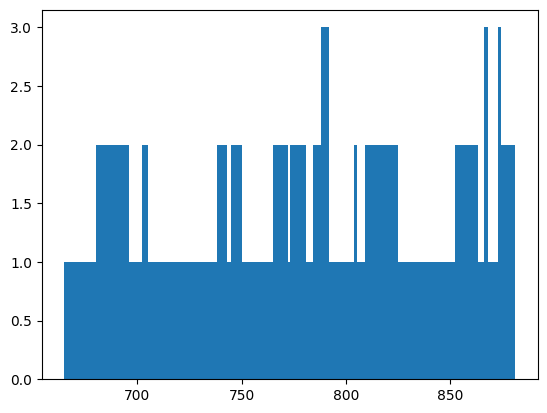

Cluster = 6
Patient ids in cluster = [665 665 671 671 677 677 678 678 678 682 683 683 684 684 685 685 686 688
 689 689 689 689 692 698 700 700 700 706 706 708 709 710 712 720 720 721
 726 728 730 734 734 740 744 744 750 754 756 758 758 761 761 762 762 766
 767 767 771 775 779 784 784 788 792 793 796 796 797 799 805 806 806 807
 811 811 813 815 816 817 817 818 820 822 822 823 823 824 824 829 830 830
 833 834 836 836 840 841 842 842 843 848 849 849 852 856 857 857 861 864
 864 865 868 868 872 876 877 879 879 879 881 882]


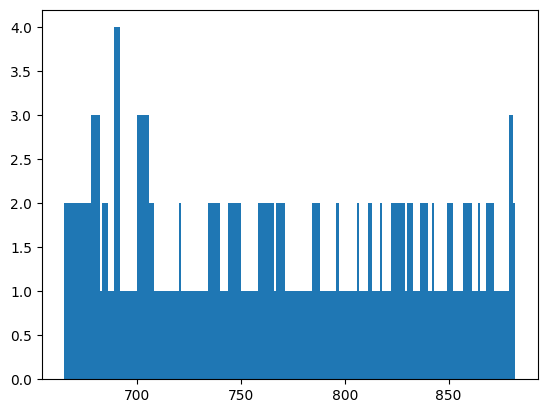

Cluster = 7
Patient ids in cluster = [669 685 686 686 691 691 691 697 697 697 701 708 708 708 710 711 713 713
 713 715 715 716 716 717 724 725 728 729 729 730 731 731 731 731 733 744
 744 753 753 756 756 759 760 764 769 771 776 782 782 782 783 783 783 783
 786 786 786 787 787 787 787 789 789 789 793 797 799 799 800 800 803 803
 803 803 807 811 812 814 814 814 818 819 821 821 821 822 826 826 827 827
 828 828 829 832 834 834 835 837 837 837 837 845 845 846 847 847 847 848
 855 855 855 858 859 859 871 871 871 874 880 880]


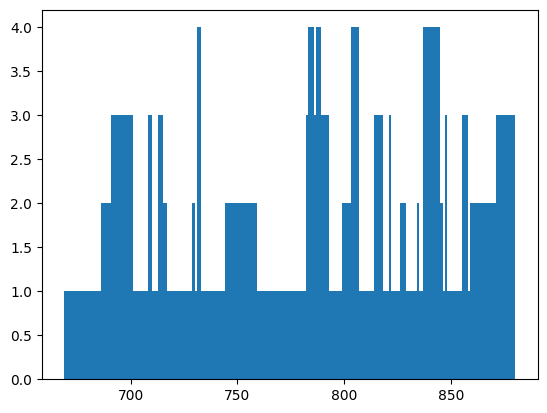

Cluster = 8
Patient ids in cluster = [662 662 662 667 667 667 674 674 675 675 679 679 679 679 694 696 703 703
 703 703 704 709 709 719 719 719 721 722 722 722 723 723 723 723 736 737
 739 739 739 743 749 749 751 751 752 752 752 755 755 763 763 764 770 770
 770 770 774 774 777 777 777 778 778 781 795 801 801 802 817 851 851 852
 854 854 860 867 868 870 870 874 875 882]


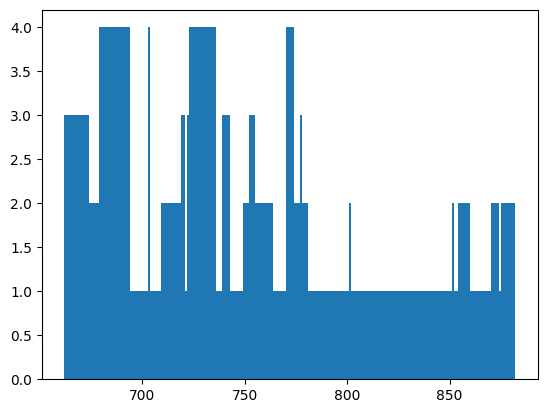

Cluster = 9
Patient ids in cluster = [663 668 669 670 670 676 677 680 683 685 695 695 700 702 705 706 710 717
 718 718 724 727 728 736 740 741 741 742 742 743 745 747 747 752 755 765
 765 772 780 780 785 785 791 794 794 798 798 798 805 811 815 816 820 823
 825 833 834 839 846 853 856 861 864 865 869 870 872 873 875 875 878 879
 881 882]


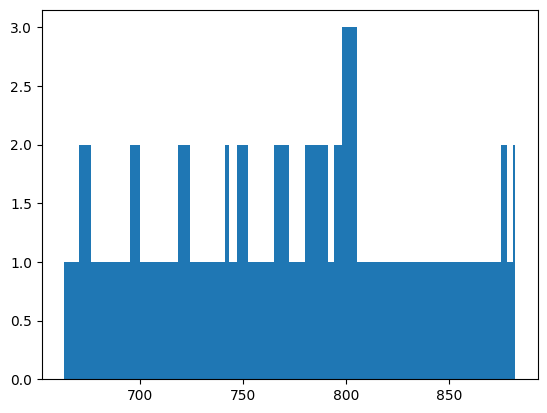

In [74]:
# Evaluation 2: perform a clustering using the embeddings
subjnum_val = subjnum[idxs_val]
# Note: I now cluster the validation embeddings; other option is to cluster train's and predict val labels?
kmeans = KMeans(n_clusters=10, random_state=0, n_init=10).fit(output_val)
labels_val = kmeans.labels_

print('Total number of patients in validation set is ' + str(len(np.unique(subjnum_val))))

# Compute recall and specificity for the K-means classifier
kmeans_label_classifier = labels_val.reshape(-1,1) == labels_val
accuracy_same_kmeans = np.sum(kmeans_label_classifier[same_subject_val])/np.sum(same_subject_val)
accuracy_diff_kmeans = np.sum(~kmeans_label_classifier[diff_subject_val])/np.sum(diff_subject_val)
print(f'Clustering using KMeans with k={kmeans.n_clusters}')
print(f'Accuracy on same: {accuracy_same_kmeans}')
print(f'Accuracy on different: {accuracy_diff_kmeans}')

# print the cluster labels and true patient id's
for g in np.unique(labels_val):
    ix = np.where(labels_val==g)
    print('Cluster = '+str(g))
    print('Patient ids in cluster = '+ str(np.sort(subjnum_val[ix])))
    # Make a histogram of how often that patient is in the cluster; it should be 4 as we do 4 scans per patient
    plt.hist(subjnum_val[ix], bins = np.unique(subjnum_val[ix]))
    plt.show()

In [75]:
# Create a scatter plot with the color being true patient id
cm = plt.cm.gist_rainbow(np.linspace(0,1,300))
# Use PCA to plot 2 important dimensions 
val_pca = PCA(n_components=2).fit_transform(output_val)# input is (nr_samples, nr_dim)
print(val_pca.shape)
it = 0
for g in np.unique(subjnum_val):
    ix = np.where(subjnum_val == g)
    plt.scatter(val_pca[ix,0], val_pca[ix,1], color = cm[it], label = g)
    it += 1
plt.legend(loc=0, prop={'size': 5})
plt.show()

ValueError: n_components=2 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

### Setup with a neural network over the raw data

In [76]:
# Create dataloader 
class ourDataset2(Dataset):
    def __init__(self, the_data, the_device):
        self.dataset = the_data
        self.the_device = the_device

    def __len__(self):
        return (self.dataset).shape[0]

    def __getitem__(self, idx):
        # Load the data
        datapoint = self.dataset[idx,:,:,:]
        batch_idx = idx
        # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
        datapoint = torch.tensor(datapoint, dtype=torch.float).to(self.the_device)
        return datapoint, batch_idx

In [77]:
class eegNet(nn.Module):
    def __init__(self, nenc, f1, t1, d2, t3, f3):
        '''
        f1: number of filters we apply in first layer
        t1: length of the filter we apply in first layer across the time dimension
        d2: number of times we apply a filter per each channel in the depthwise conv
        t3: length of filter in depthwise seperable conv across time
        f3: number of filters in depthwise separable conv when summing over all input channels
        '''
        super().__init__()
        # first layer: f1 2d conv's per nr_voxel
        self.conv1 = nn.Conv2d(1, f1, (1,t1)) #in channels, out channels, kernel size
        self.batchnorm1 = nn.BatchNorm2d(f1)
        # second layer: depthwise conv
        self.conv2 = nn.Conv2d(f1, f1*d2, (360, 1), groups = f1)
        self.batchnorm2 = nn.BatchNorm2d(f1*d2)
        self.pooling2 = nn.AvgPool2d((1,4))
        # third layer: depthwise separable conv
        self.conv3 = nn.Conv2d(f1*d2, f1*d2, (1,t3), groups = (f1*d2)) #depthwise
        self.conv4 = nn.Conv2d(f1*d2, f3, (1,1)) #separable
        self.batchnorm3 = nn.BatchNorm2d(f3)
        self.pooling3 = nn.AvgPool2d((1,8))

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = self.batchnorm1(x)
        
        # Layer 2
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.elu(x)
        x = self.pooling2(x)
        
        # Layer 3
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.batchnorm3(x)
        x = F.elu(x)
        x = self.pooling3(x)
        
        # FC Layer
        x = torch.flatten(x,1)
        # linear one that maps to encoding dimension
        fshape = x.shape[1]
        fc1 = nn.Linear(fshape, nenc)
        x = fc1(x)
        
        return x

In [78]:
batch_size = 32
dim = raw_features.shape[1]
nenc = 10
nr_epochs = 10

loss_c = 'simple'
if loss_c == 'simple':
    eps = 2
    lr = .01
elif loss_c == 'lifted':
    eps = 2
    lr = .1

cnet = eegNet(nenc, f1=5, t1=64, d2=1, t3=32, f3=1)
device = 'cpu'
optimizer = optim.SGD(cnet.parameters(), lr=lr)

# reshape input to Nx1x360x1100
raw_features = raw_features.reshape(all_features.shape[0], 1, 360, 1100)

# Create train and test datasets
perc_train = 75
nr_samples = raw_features.shape[0]
print('Number of total samples= '+ str(nr_samples))
num_train = int(np.round(nr_samples / 100 * perc_train))
# I want to select a set of patients as train and the rest as val (point being, both should contain enough same patients)
idxs = np.arange(nr_samples)
idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]
# shuffle after selecting
np.random.shuffle(idxs_train)
np.random.shuffle(idxs_val)

same_subject_train = same_subject[idxs_train[:,None], idxs_train[None,:]]
same_subject_val = same_subject[idxs_val[:,None], idxs_val[None,:]]
diff_subject_train = diff_subject[idxs_train[:,None], idxs_train[None,:]]
diff_subject_val = diff_subject[idxs_val[:,None], idxs_val[None,:]]
raw_features_train = raw_features[idxs_train,:]
raw_features_val = raw_features[idxs_val,:]

# Load data
dataset_train = ourDataset2(raw_features_train, the_device=device)
train_dataloader = DataLoader(dataset_train, batch_size=batch_size) #shuffle is false as i've shuffled already

for epoch in range(nr_epochs):
    # iterate over all data 
    for it, (d,batch_idx) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        batch_idx = batch_idx.detach().numpy()
        # get submatrices of same and diff
        same = torch.tensor(same_subject_train[batch_idx[:,None], batch_idx[None,:]])
        diff = torch.tensor(diff_subject_train[batch_idx[:,None], batch_idx[None,:]])
        # pass through model
        output = cnet.forward(d)
        # Compute the loss value
        if loss_c == 'simple':
            loss = contr_loss_simple(output, same, diff, eps)
        elif loss_c == 'lifted':
            loss = contr_loss_lifted(output, same, diff, eps)
        # zero the parameter gradients
        optimizer.zero_grad()
        # Compute the gradients
        loss.backward()
        # Take the optimisation step
        optimizer.step()
    print(epoch, loss.item())

print('Finished training')
print('Final loss ' + str(loss.item()))

# Empty memory
del dataset_train, train_dataloader
gc.collect()

Number of total samples= 3532


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [12:54<00:00,  9.34s/it]


0 1.6581165790557861


 35%|█████████████████████████████████████████████████▌                                                                                            | 29/83 [03:53<07:14,  8.05s/it]


KeyboardInterrupt: 

In [ ]:
dataset_val = ourDataset2(raw_features_val, the_device=device)
val_dataloader = DataLoader(dataset_val, batch_size=len(idxs_val))

# pass through model
output_val = []
index_val = []
for it, (d,batch_idx) in enumerate(val_dataloader):
    print(it)
    output = cnet.forward(d)
    output_val.append(output.detach().numpy())
    index_val.append(batch_idx.detach().numpy())
output_val = np.vstack(output_val)
index_val = np.hstack(index_val)

dist_val = cdist(output_val, output_val)
# get submatrices of same and diff
same_val_true = same_subject_val[index_val[:,None], index_val[None,:]]
diff_val_true = diff_subject_val[index_val[:,None], index_val[None,:]]

In [ ]:
# Evaluation 0: mean / median plot; 
# We want the distance for different to be very different from distance for same
sames = dist_val[same_val_true]
diffs = dist_val[diff_val_true]
plt.hist(sames, bins=100, density=True, alpha=.5)
plt.hist(diffs, bins=100, density=True, alpha=.5)
plt.xlabel("Similarity on validation data")
plt.legend(["Same subject", "Different subject"])
plt.title(f"Difference of medians: {np.median(sames)-np.median(diffs):.2f}\nDifference of means: {np.mean(sames)-np.mean(diffs):.2f}")
plt.show()

In [ ]:
# Evaluation 1: we compute the accuracy of the same/diff classification
threshold = eps # REQUIRES LOTS OF TUNING
same_val_pred = (dist_val<=threshold) # True if above threshold
diff_val_pred = (dist_val>threshold)

accuracy_same = np.sum((same_val_pred==same_val_true) & (same_val_true==True))/np.sum(same_val_true)
accuracy_diff = np.sum((diff_val_true==diff_val_pred) & (diff_val_true==True)) / np.sum(diff_val_true)
print('Accuracy on same: '+str(accuracy_same))
print('Accuracy on different: '+str(accuracy_diff))